# Sensitivity Analysis
Last update: 4 March 2025

$\large{\color {red} {\text{This notbook is posted as a place holder}}}$  

In [1]:
#| echo: false
import random
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
from tabulate import tabulate
init_printing()

# SYMBOLIC ANALYSIS
Symbolic analysis presented in this report employes the MNA technique to generate network equations from the filter's netlist with the circuit's elements are represented by symbols. SymPy is used to solve the system of equations in symbolic form to obtain analytic expressions for the filter's voltage transfer function. The symbolic expressions can in some cases provide a deeper understanding of how each component contributes to the circuit's operation that can complement numerical simulations.

## Circuit Netlist
The netlist generated by LTSpice from the schematic is shown below. Some edits were made to fix up the formating of the component values and the Op Amp declaration. The nodes were labeled in the schematic, otherwise LTSpice will use default labels such as N001, N002 etc. and the smna function wants integer values for the node numbers and these need to be consecutively ordered with no gaps in the numbering.

```
    * Bandpass-Twin-T-Active-Filter.asc
    R1 3 1 15k
    R2 4 5 186k
    R3 2 5 15k
    C1 5 1 10n
    C2 4 3 910p
    C3 2 3 10n
    XU1 4 0 2 opamp Aol=100K GBW=10Meg
    V1 1 0 1 AC 1
    .lib opamp.sub
    .ac dec 1000 100 10k
    .backanno
    .end
```

Generation of the netlist from a schematic caputure program is comvinent and less error propne than generating the netwlist by hand. A visiual inspection of the schematic insurs that the circuit to be analyzed is correct and it follows that the netlist is alos correct. This is espically true or larger more complicated schamitics. 

The cleaned up netlist was copied to the cell below. The tripple quotes allow text strings to span multiple lines since the line breaks are preserved.

In [2]:
#| echo: true
example_net_list = '''
* Bandpass-Twin-T-Active-Filter.asc
R1 3 1 15e3
R2 4 5 186e3
R3 2 5 15e3
C1 5 1 10e-9
C2 4 3 910e-12
C3 2 3 10e-9
O1 4 0 2
V1 1 0 1
'''

## Generate Network Equations 
The function ```SymMNA.smna(example_net_list)``` implements the MNA method on the filter's netlist. Stamps which are templates for modifying the B, C and D matrices are used to facilitate the construction of the matrices. The stamps used in this implementation of the MNA follow the stamps of [4]. The function is divided in the following sections.  

- The preprocessor reads in the netlist text file and removes comments, extra spaces and blank lines. The first letter of the element type is capitalized to make subsequent parsing of the file easier. The number of lines are counted and the number of entries on each line are checked to make sure the count is consistent with the element type.
- The parser code loads the preprocessed netlist into a data frame.  A report is generated which consists of a count of the element types in the netlist.
- Matrix formulation: Each of the matrices and vectors are generated.
- Circuit equation generation: The circuit equations are generated in a ```for``` loop. Sympy automatically does some simplification according to its default settings. The Laplace variable $s$ is used when inductors and capacitors are included in the circuit.

There is a limited amount of error checking performed. The number of items on each line in the netlist is checked to make sure the count is correct depending on the element type. The node numbering needs to be consecutive with no skipped numbers, otherwise empty rows or columns will be included in the matrix. Unknown element types create an error.

The function takes one argument which is a text string that is the circuit’s netlist. The format of the netlist is very similar to the standard spice netlist and any of the required changes can be easily made with a text editor. The function returns six items.  

1. report - a text string, which is the netlist report.
2. df - a Pandas data frame, which the circuit’s net list info loaded into a data frame.
3. df2 - a Pandas data frame, which contains the branches with unknown currents.
4. $A$ - a SymPy matrix, which is $(m+n)$ by $(m+n)$, where $n$ is the number of nodes and $m$ is the number of current unknowns. $A$ is the combination of four smaller matrices, $G$, $B$, $C$, and $D$. These matrices are described in the GitHub repository.
5. $X$ - a list that holds the unknown node voltages and the currents through the independent voltage sources.
6. $Z$ - a list that holds the independent voltage and current sources

The netlist can be generated by hand or exported from a schematic capture program and pasted into the JupyterLab notebook.

In [3]:
#| echo: true
report, network_df, df2, A, X, Z = SymMNA.smna(example_net_list)

Convert the lists of unknown node voltages and currents as well as the list of independednt voltage and current sources into SymPy matrices. 

In [4]:
#| echo: true
X = Matrix(X)
Z = Matrix(Z)

Use the SymPy function ```Eq``` to formulate the network equations.

In [5]:
#| echo: true
NE_sym = Eq(A*X,Z)

The equations, ```NE_sym```, define the mathematical relationship between voltages and currents in the filter circuit in terms of node voltages, $v_1$, $v_2$ etc., components $R_1$, $C_1$ etc., the Laplace variable $s$ and the indepenedent voltage source $V_1$. The equations are shown below:

In [6]:
#| echo: true

# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '<p>${:s} = {:s}$</p>'.format(latex(NE_sym.lhs[i]),
        latex(NE_sym.rhs[i]))

Markdown(temp)

<p>$- C_{1} s v_{5} + I_{V1} + v_{1} \left(C_{1} s + \frac{1}{R_{1}}\right) - \frac{v_{3}}{R_{1}} = 0$</p><p>$- C_{3} s v_{3} + I_{O1} + v_{2} \left(C_{3} s + \frac{1}{R_{3}}\right) - \frac{v_{5}}{R_{3}} = 0$</p><p>$- C_{2} s v_{4} - C_{3} s v_{2} + v_{3} \left(C_{2} s + C_{3} s + \frac{1}{R_{1}}\right) - \frac{v_{1}}{R_{1}} = 0$</p><p>$- C_{2} s v_{3} + v_{4} \left(C_{2} s + \frac{1}{R_{2}}\right) - \frac{v_{5}}{R_{2}} = 0$</p><p>$- C_{1} s v_{1} + v_{5} \left(C_{1} s + \frac{1}{R_{3}} + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{3}} - \frac{v_{4}}{R_{2}} = 0$</p><p>$v_{1} = V_{1}$</p><p>$v_{4} = 0$</p>

The two lines of Python code below turn the free symbols from the ```NE_sym``` equations into SymPy variables and the element values contained in the netlist are put into a Python dictionary data structure to be used in the numerical solutions later in this report.

In [7]:
#| echo: true
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))
nominal_component_value = SymMNA.get_part_values(network_df)

## Solve the Network Equations
The SymPy function ```solve``` is used to obtain the node voltages and independent voltage source currents.

In [8]:
#| echo: true
U_sym = solve(NE_sym,X)

The solution to the network equations are the node voltages expressed in terms of the Laplace variable $s$ are displayed below.

In [9]:
#| echo: true
temp = ''
for i in U_sym.keys():
    if str(i)[0] == 'v': # only display the node voltages
        temp += '<p>${:s} = {:s}$</p>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

<p>$v_{1} = V_{1}$</p><p>$v_{2} = \frac{- C_{1} C_{2} R_{1} R_{3} V_{1} s^{2} - C_{1} C_{2} R_{2} R_{3} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{3} V_{1} s^{2} - C_{1} R_{3} V_{1} s - C_{2} R_{2} V_{1} s - C_{2} R_{3} V_{1} s}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{3} R_{1} s + 1}$</p><p>$v_{3} = \frac{- C_{1} C_{3} R_{1} R_{3} V_{1} s^{2} + V_{1}}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{3} R_{1} s + 1}$</p><p>$v_{4} = 0$</p><p>$v_{5} = \frac{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} V_{1} s^{3} - C_{2} R_{2} V_{1} s}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + C_{2} C_{3} R_{1} R_{2} s^{2} + C_{2} C_{3} R_{1} R_{3} s^{2} + C_{2} R_{1} s + C_{3} R_{1} s + 1}$</p>

### Voltage Transfer Function $H(s)=\frac {v_2(s)}{v_1(s)}$
The voltage transfer function, $H(s)$, for the filter  is generated and displayed by the following code:

In [10]:
#| echo: true
H_sym = cancel(U_sym[v2]/U_sym[v1],s)
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{s^{2} \left(- C_{1} C_{2} R_{1} R_{3} - C_{1} C_{2} R_{2} R_{3} - C_{1} C_{3} R_{1} R_{3}\right) + s \left(- C_{1} R_{3} - C_{2} R_{2} - C_{2} R_{3}\right)}{C_{1} C_{2} C_{3} R_{1} R_{2} R_{3} s^{3} + s^{2} \left(C_{2} C_{3} R_{1} R_{2} + C_{2} C_{3} R_{1} R_{3}\right) + s \left(C_{2} R_{1} + C_{3} R_{1}\right) + 1}$

This expression agrees with [1 eq. (1)]. The numerator is a second order polynominal and the demominator is third order polynominal in terms of $s$. Generally, the order of the dominator is equal to the number of reactive elements in the circuit. The roots of the numerator polynominal are called the zeros of the transfer function and the roots of the denominator are called the poles of the transfer function.

## Sensitivity Analysis
When look at a filter, especially in the context of a design review, the circuit designer will want to examine the circuit sensitivity.

Prototype Sensitivity Analysis in seperate notebook. 

Twin-T_BPF_Sensitivity_Analysis.ipynb

## Monte Carlo Tolerance Analysis

- use 1000kHz filter with values from table I

## Worst Case Tolerance Analysis

- use 1000kHz filter with values from table I

The calculations above show that within the audio range the deviation of the preamp amplitude response from the RIAA curve varies from -0.044 to 0.066 dB when the nominal component values are used. 

### Sensitivity analysis
All circuits have characteristics that depend on the values of the component. The sensitivity of a circuit's performance is a measure of how much a particular circuit characteristic changes as a particular component value varies. In this analysis I'll look at the changes of each pole or zero relative to the component's value.

The root sensitivity function $S_x^y$ gives the change occurring in filter characteristic per $\delta y/ \delta x$.  

$S_x^y$ is read as the sensitivity of the characteristic (i.e. y = $\omega_n,$ or Q or some other characteristic) with respect to the element x.

$S_x^y = \frac {x}{y} \frac{\delta y}{\delta x}$

Where x is the filter component that is varied and y is the filter characteristic ($\omega_n,$ or Q etc.) that we wish to evaluate as x is varied.

The preamp transfer function in symbolic form is, H_preamp_sym, and we can get the numerator and denominator with the SymPy fraction function.

In [11]:
#| echo: true
H_sym_num, H_sym_denom = fraction(H_sym,s) #returns numerator and denominator

The SymPy solve function is used to find the root of the numerator and denominator polynomials.

In [12]:
H_sym_zeros = solve(H_sym_num,s)
H_sym_poles = solve(H_sym_denom,s)

#### Zeros
How many roots are there for the numerator polynomial?

In [13]:
print('there are {:d} zeros'.format(len(H_sym_zeros)))

there are 2 zeros


#### Z0
The first zero is at DC.

In [14]:
H_sym_Z0 = H_sym_zeros[0]
H_sym_Z0

#### Z1
The second zero is given symbolically by the expression:

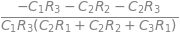

In [15]:
H_sym_Z1 = H_sym_zeros[1]
H_sym_Z1

What are the components that determine Z1?

In [16]:
print('the components that determine Z1 are: {:s} '.format(str(H_sym_Z1.free_symbols)))

the components that determine Z1 are: {R2, C1, R3, C3, R1, C2} 


What is the locations of Z1?

In [17]:
print('location of zero: {:.2f} Hz'.format(N(H_sym_Z1.subs(nominal_component_value))/(2*np.pi)))

location of zero: -1061.03 Hz


We can find the sensitivity of Z1 to C1 with the following operation.

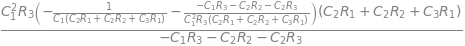

In [18]:
S_C1_H_sym_Z1 = (C1/H_sym_Z1)*(H_sym_Z1.diff(C1))
S_C1_H_sym_Z1

Evaluating this numerically with the component values, we get the sensitivity of Z1 to C1.

In [19]:
print('the sensitivity of Z1 to C1 is: {:.2f}'.format(N(S_C1_H_sym_Z1.subs(nominal_component_value))))

the sensitivity of Z1 to C1 is: -0.55


Doing the math with SymPy, we can get the sensitivity of Z1 to the other components. 

In [20]:
S_R1_H_sym_Z1 = (R1/H_sym_Z1)*(H_sym_Z1.diff(R1))
print('the sensitivity of Z1 to R1 is: {:.2f}'.format(N(S_R1_H_sym_Z1.subs(nominal_component_value))))

the sensitivity of Z1 to R1 is: -0.49


In [21]:
S_R2_H_sym_Z1 = (R2/H_sym_Z1)*(H_sym_Z1.diff(R2))
print('the sensitivity of Z1 to R2 is: {:.2f}'.format(N(S_R2_H_sym_Z1.subs(nominal_component_value))))

the sensitivity of Z1 to R2 is: 0.00


In [22]:
S_R3_H_sym_Z1 = (R3/H_sym_Z1)*(H_sym_Z1.diff(R3))
print('the sensitivity of Z1 to R3 is: {:.2f}'.format(N(S_R3_H_sym_Z1.subs(nominal_component_value))))

the sensitivity of Z1 to R3 is: -0.51


In [23]:
S_C1_H_sym_Z1 = (C1/H_sym_Z1)*(H_sym_Z1.diff(C1))
print('the sensitivity of Z1 to C1 is: {:.4f}'.format(N(S_C1_H_sym_Z1.subs(nominal_component_value))))

the sensitivity of Z1 to C1 is: -0.5494


In [24]:
S_C2_H_sym_Z1 = (C2/H_sym_Z1)*(H_sym_Z1.diff(C2))
print('the sensitivity of Z1 to C2 is: {:.2f}'.format(N(S_C2_H_sym_Z1.subs(nominal_component_value))))

the sensitivity of Z1 to C2 is: 0.00


In [25]:
S_C3_H_sym_Z1 = (C3/H_sym_Z1)*(H_sym_Z1.diff(C3))
print('the sensitivity of Z1 to C3 is: {:.2f}'.format(N(S_C3_H_sym_Z1.subs(nominal_component_value))))

the sensitivity of Z1 to C3 is: -0.45


Later, we are doing the worst case analysis, we can ignore C2. 

#### Poles
How many poles are there in the preamp transfer function?

In [26]:
print('there are {:d} poles in the transfer function'.format(len(H_sym_poles)))

there are 3 poles in the transfer function


#### P0
The first pole is:

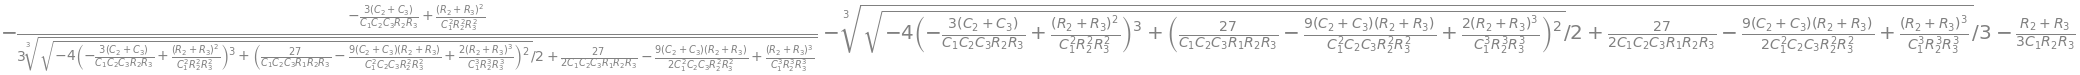

In [27]:
H_sym_P0 = H_sym_poles[0]
H_sym_P0

comment

In [28]:
print('P0: {:.2f}Hz'.format(N(H_sym_P0.subs(nominal_component_value))/(2*np.pi)))

P0: -1061.03Hz


In [29]:
S_R1_H_sym_P0 = (R1/H_sym_P0)*(H_sym_P0.diff(R1))
print('the sensitivity of P0 to R1 is: {:.2f}'.format(N(S_R1_H_sym_P0.subs(nominal_component_value))))

the sensitivity of P0 to R1 is: -0.49


In [30]:
S_R2_H_sym_P0 = (R2/H_sym_P0)*(H_sym_P0.diff(R2))
print('the sensitivity of P0 to R1 is: {:.2f}'.format(N(S_R2_H_sym_P0.subs(nominal_component_value))))

the sensitivity of P0 to R1 is: 0.00


In [31]:
S_R3_H_sym_P0 = (R3/H_sym_P0)*(H_sym_P0.diff(R3))
print('the sensitivity of P0 to R3 is: {:.2f}'.format(N(S_R3_H_sym_P0.subs(nominal_component_value))))

the sensitivity of P0 to R3 is: -0.51


In [32]:
S_C1_H_sym_P0 = (C1/H_sym_P0)*(H_sym_P0.diff(C1))
print('the sensitivity of P0 to C1 is: {:.2f}'.format(N(S_C1_H_sym_P0.subs(nominal_component_value))))

the sensitivity of P0 to C1 is: -0.55


In [33]:
S_C2_H_sym_P0 = (C2/H_sym_P0)*(H_sym_P0.diff(C2))
print('the sensitivity of P0 to C21 is: {:.2f}'.format(N(S_C2_H_sym_P0.subs(nominal_component_value))))

the sensitivity of P0 to C21 is: -0.00


In [34]:
S_C3_H_sym_P0 = (C3/H_sym_P0)*(H_sym_P0.diff(C3))
print('the sensitivity of P0 to C3 is: {:.2f}'.format(N(S_C3_H_sym_P0.subs(nominal_component_value))))

the sensitivity of P0 to C3 is: -0.45


#### P1
The second pole is:

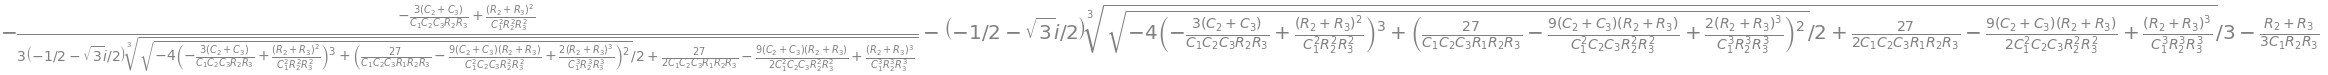

In [35]:
H_sym_P1 = H_sym_poles[1]
H_sym_P1

The pole P1 evaluates to a frequency near DC.

In [36]:
#print('P1: {:.2f}Hz'.format(N(H_sym_P1.subs(nominal_component_value))/(2*np.pi)))
print('P1: {:.2f}Hz'.format(abs(N(H_sym_P1.subs(nominal_component_value))/(2*np.pi))))

P1: 998.84Hz


In [37]:
S_R1_H_sym_P1 = (R1/H_sym_P1)*(H_sym_P1.diff(R1))
print('the sensitivity of P1 to R1 is: {:.2f}'.format(abs(N(S_R1_H_sym_P1.subs(nominal_component_value)))))

the sensitivity of P1 to R1 is: 0.37


In [38]:
S_R2_H_sym_P1 = (R2/H_sym_P1)*(H_sym_P1.diff(R2))
print('the sensitivity of P1 to R2 is: {:.2f}'.format(abs(N(S_R2_H_sym_P1.subs(nominal_component_value)))))

the sensitivity of P1 to R2 is: 0.50


In [39]:
S_R3_H_sym_P1 = (R3/H_sym_P1)*(H_sym_P1.diff(R3))
print('the sensitivity of P1 to R3 is: {:.2f}'.format(abs(N(S_R3_H_sym_P1.subs(nominal_component_value)))))

the sensitivity of P1 to R3 is: 0.35


In [40]:
S_C1_H_sym_P1 = (C1/H_sym_P1)*(H_sym_P1.diff(C1))
print('the sensitivity of P1 to C1 is: {:.2f}'.format(abs(N(S_C1_H_sym_P1.subs(nominal_component_value)))))

the sensitivity of P1 to C1 is: 0.35


In [41]:
S_C2_H_sym_P1 = (C2/H_sym_P1)*(H_sym_P1.diff(C2))
print('the sensitivity of P1 to C2 is: {:.2f}'.format(abs(N(S_C2_H_sym_P1.subs(nominal_component_value)))))

the sensitivity of P1 to C2 is: 0.50


In [42]:
S_C3_H_sym_P1 = (C3/H_sym_P1)*(H_sym_P1.diff(C3))
print('the sensitivity of P1 to C3 is: {:.2f}'.format(abs(N(S_C3_H_sym_P1.subs(nominal_component_value)))))

the sensitivity of P1 to C3 is: 0.37


#### P2
The 3rd pole is:

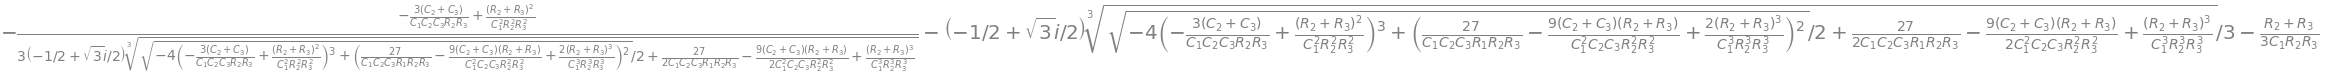

In [43]:
H_sym_P2 = H_sym_poles[2]
H_sym_P2

In [44]:
print('the components that determine P2 are: {:s} '.format(str(H_sym_P2.free_symbols)))

the components that determine P2 are: {R2, C1, R3, C3, R1, C2} 


In [45]:
print('P2: {:.2f}Hz'.format(abs(N(H_sym_P2.subs(nominal_component_value))/(2*np.pi))))

P2: 998.84Hz


In [46]:
S_R1_H_sym_P2 = (R1/H_sym_P2)*(H_sym_P2.diff(R1))
print('the sensitivity of P2 to R1 is: {:.2f}'.format(abs(N(S_R1_H_sym_P2.subs(nominal_component_value)))))

the sensitivity of P2 to R1 is: 0.37


In [47]:
S_R2_H_sym_P2 = (R2/H_sym_P2)*(H_sym_P2.diff(R2))
print('the sensitivity of P2 to R2 is: {:.2f}'.format(abs(N(S_R2_H_sym_P2.subs(nominal_component_value)))))

the sensitivity of P2 to R2 is: 0.50


In [48]:
S_R3_H_sym_P2 = (R3/H_sym_P2)*(H_sym_P2.diff(R3))
print('the sensitivity of P2 to R3 is: {:.2f}'.format(abs(N(S_R3_H_sym_P2.subs(nominal_component_value)))))

the sensitivity of P2 to R3 is: 0.35


In [49]:
S_C1_H_sym_P2 = (C1/H_sym_P2)*(H_sym_P2.diff(C1))
print('the sensitivity of P2 to C1 is: {:.2f}'.format(abs(N(S_C1_H_sym_P2.subs(nominal_component_value)))))

the sensitivity of P2 to C1 is: 0.35


In [50]:
S_C2_H_sym_P2 = (C2/H_sym_P2)*(H_sym_P2.diff(C2))
print('the sensitivity of P2 to C2 is: {:.2f}'.format(abs(N(S_C2_H_sym_P2.subs(nominal_component_value)))))

the sensitivity of P2 to C2 is: 0.50


In [51]:
S_C3_H_sym_P2 = (C3/H_sym_P2)*(H_sym_P2.diff(C3))
print('the sensitivity of P2 to C3 is: {:.2f}'.format(abs(N(S_C3_H_sym_P2.subs(nominal_component_value)))))

the sensitivity of P2 to C3 is: 0.37


In [52]:
nominal_component_value

{C₁: 1e-08, C₂: 9.1e-10, C₃: 1e-08, O₁: nan, R₁: 15000.0, R₂: 186000.0, R₃: 15
000.0, V₁: 1.0}

In [53]:
stop

NameError: name 'stop' is not defined

In the worst case analysis below, the components that have sensitivities greater than 0.05 are the ones that factor into the worst case analysis.

## Monte Carlo Tolerance Analysis

- use 1000kHz filter with values from table I


### Component selection
The table below lists each of the components used in the preamp along with a link to the [Digikey](https://www.digikey.com/) pages for each of the components in the preamp. Digikey is a larger distributor of electronic components in the US. All the components have operating temperature ranges that exceed the normal household environment.

The resistors chosen are all 1% [Metal film](https://en.wikipedia.org/wiki/Resistor) type resistors. Metal film resistors possess good noise characteristics and low nonlinearity due to a low voltage coefficient. They are also beneficial due to long-term stability.

The capacitors are all polypropylene [Film capacitor](https://en.wikipedia.org/wiki/Film_capacitor) types. Polystyrene or polypropylene are considered the best for audio applications.


$R_1$ is implemented with a fixed 15k$\Omega$ resistor

$R_2$ is a fixed 100 k$\Omega$ resistor in series with a 100 k$\Omega$ potentiometer wired as a variable resistor.

$R_3$ for each filter is a 20 k$\Omega$ potentiometer wired as a variable resistor.

| Ref | Value | Description | Digikey PN |
|---|---|---|---|
| R1 | 15k | ±1% 1/4W Metal Film | [RNF14FTD15K0](https://www.digikey.com/en/products/detail/stackpole-electronics-inc/RNF14FTD15K0/1706645) |
| R2a | 150k | ±1% 1/4W Metal Film, 150 kOhms ±1% 0.25W, 1/4W Through Hole Resistor Axial Metal Film | [RNF14FTD100K](https://www.digikey.com/en/products/detail/yageo/MFR-25FRF52-150K/14631) |
| R2b | 100k pot | 100 kOhms 0.25W, 1/4W PC Pins Through Hole Trimmer Potentiometer Cermet 12.0 Turn Top Adjustment, Temperature Coefficient ±150ppm/°C| [PV37W104C01B00](https://www.digikey.com/en/products/detail/bourns-inc/PV37W104C01B00/666598) |
| R3 | 20k pot | 20 kOhms 0.25W, 1/4W PC Pins Through Hole Trimmer Potentiometer Cermet 12.0 Turn Top Adjustment, Temperature Coefficient ±150ppm/°C | [PV37W203C01B00](https://www.digikey.com/en/products/detail/bourns-inc/PV37W203C01B00/666603) |
| C1, C3 | 10n | 2% Film Capacitor 25V 63V Polypropylene, CAP FILM 10000PF 5% 63VDC RADIAL, 10000 pF Film Capacitor 40V 63V Polypropylene (PP) Radial | [PFR5103J63J12L4BULK](https://www.digikey.com/en/products/detail/kemet/PFR5103J63J12L4BULK/3465888?s=N4IgjCBcoMxaBjKAzAhgGwM4FMA0IB7KAbRACYBWABjgF18AHAFyhAGUmAnASwDsBzEAF98ATiqj4IJJDRY8hEiBgAOFQHYYANhD0QzVhx4Dh%2BMGVFxo0lBhz4ikUmS1UtFCHoOR2XPoJFyKgAWSWsZOXtFJ3AqOKoAAgYAMV1GFh8AVV5uJgB5ZABZbFRMAFdObFMQAFoyKRkuMoVHUgpdIU6gA) |
| C2 | 910p | CAP FILM 910PF 5% 630VDC RADIAL, 910 pF Film Capacitor 300V 630V Polypropylene (PP), Metallized Radial | [BFC237510911](https://www.digikey.com/en/products/detail/vishay-beyschlag-draloric-bc-components/BFC237510911/5363491?s=N4IgjCBcoJwAwyqAxlAZgQwDYGcCmANCAPZQDaIAzABzUDsALBALpEAOALlCAMocBOASwB2AcxABfIgCY4DRNBCpImXIRLkQMMHAAEbAGIhWITtwCqwwRwDyaALJ4MOAK788kogFppSJVAEXdVJICgBWYwkooA) |


The parts in this list are considered good choices for a first pass at the bill of materials. The size of the production run and the piece part cost are also factors which must be considered if the preamp is going to be built. One thing to notice is that Co, the 200 $\mu$ F capacitor is expensive. The use of a polypropylene film capacitor for this component is consistent with the advice of keeping all capacitors in the audio path polystyrene or polypropylene.   

### Monte Carlo simulation
In this analysis the circuit equations are solved after assigning random element values from within the tolerance band to the components. This simulates building a large number of circuits with components chosen at random from bins or reals of components during the board stuffing process. All the components are required to meet their specifications, but are allowed to have some variation according to their tolerance. For example a 1% 2k resistor can range from 1980 to 2020 $\Omega$. In addition to the components initial tolerance, the temperature coefficient and aging of parameters can also be included. 

In this simulation, I'm only including the initial tolerances of parameters and I'm assuming the distribution is uniform. The NumPy function random.uniform is used to generate the random values within the tolerance range, however, for this function, the high end-point value may or may not be included in the range depending on floating-point rounding, so if this is important, some adjustments to the code are required. The NumPy function random.seed is used to re-seed the random number generator. 

In [54]:
num = 20 # number of simulations to run
new_x_axis_range = np.logspace(1.9, 4.1, 1000, endpoint=True)*2*np.pi # x axis data values

# make some arrays to the hold the results of each run
mag_ans = np.zeros(shape=(num,len(new_x_axis_range)))
phase_ans = np.zeros(shape=(num,len(new_x_axis_range)))

component_values_tol = nominal_component_value.copy() # make a copy

random.seed(a=None, version=2) # re-seed the random number generator

The following takes about 15 seconds to run on for num=20 on an i3 machine.

## Nominal Frequency Response

In [55]:
equ_N = NE_sym.subs(nominal_component_value)

U = solve(equ_N,X)

H = (U[v2]/U[v1]).cancel()

H_num, H_denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(H_num, s).all_coeffs(), dtype=float)
b = np.array(Poly(H_denom, s).all_coeffs(), dtype=float)

sys_tf = signal.TransferFunction(a,b)

x = np.logspace(1.9, 4.1, 1000, endpoint=True)*2*np.pi # x axis data values
w, mag, phase = signal.bode(sys_tf, w=x) # returns: rad/s, mag in dB and phase in deg
max_mag = mag.max()

In [56]:
max_mag

## Monte Carlo Run

In [57]:
for i in range(0,num):

    component_values_tol[R1] = random.uniform(nominal_component_value[R1]-nominal_component_value[R1]*0.01, nominal_component_value[R1]+nominal_component_value[R1]*0.01)
    component_values_tol[R2] = random.uniform(nominal_component_value[R2]-nominal_component_value[R2]*0.01, nominal_component_value[R2]+nominal_component_value[R2]*0.02)    
    component_values_tol[R3] = random.uniform(nominal_component_value[R3]-nominal_component_value[R3]*0.01, nominal_component_value[R3]+nominal_component_value[R3]*0.02)

    component_values_tol[C1] = random.uniform(nominal_component_value[C1]-nominal_component_value[C1]*0.02, nominal_component_value[C1]+nominal_component_value[C1]*0.02)
    component_values_tol[C2] = random.uniform(nominal_component_value[C2]-nominal_component_value[C2]*0.01, nominal_component_value[C2]+nominal_component_value[C2]*0.05)
    component_values_tol[C3] = random.uniform(nominal_component_value[C3]-nominal_component_value[C3]*0.1, nominal_component_value[C3]+nominal_component_value[C3]*0.02)

    # enter the element values
    equ_tol = NE_sym.subs(component_values_tol)

    U_tol = solve(equ_tol,X)

    H_tol = U_tol[v2]/U_tol[v1]

    # Extract the numerator and denominator polynomials so that the system can be defined in SciPy.
    H_tol_num, H_tol_denom = fraction(H_tol) #returns numerator and denominator

    # convert symbolic to numpy polynomial
    a = np.array(Poly(H_tol_num, s).all_coeffs(), dtype=float)
    b = np.array(Poly(H_tol_denom, s).all_coeffs(), dtype=float)
    sys_tf_tol = signal.TransferFunction(a,b)

    w_sys_tf_tol, mag_sys_tf_tol, phase_sys_tf_tol = sys_tf_tol.bode(w=new_x_axis_range)
    
    # save the results from each run
    mag_ans[i] = mag_sys_tf_tol
    phase_ans[i] = phase_sys_tf_tol

### Filter deviation from nominal response

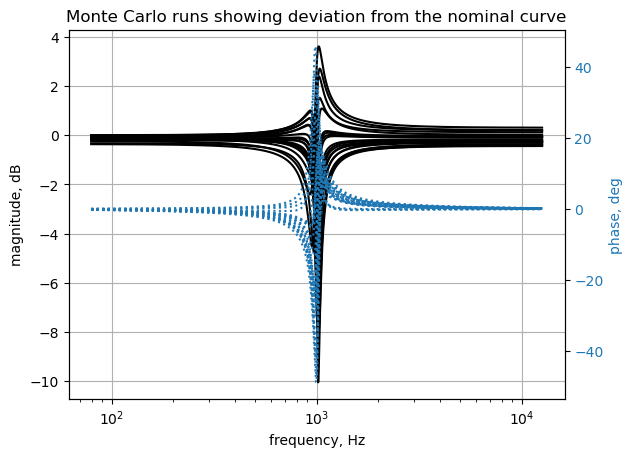

In [58]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

for i in range(0,num):
    plt.semilogx(w/(2*np.pi), mag - mag_ans[i],'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-0.3,0.3))
plt.grid()
#plt.axvspan(20, 20e3, color='y', alpha=0.3)

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

for i in range(0,num):
    plt.semilogx(w/(2*np.pi), phase - phase_ans[i],':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monte Carlo runs showing deviation from the nominal curve')
plt.show()

The Monte Carlo simulation shows that the preamp amplitude response deviation from the RIAA curve can very from -0.2 to 0.3 dB over the audio band. If the performance requirement for this preamp was to be within $\pm$ 0.1 dB of the RIAA curve, then some redesign or tighter component tolerancing is required.   

### Worst case analysis
In a worst case analysis, we would look at:   

- minimum and maximum values of the initial component tolerance  
- maximum or minimum temperature coefficients of the parameters  
- maximum aging or drift of parameter values  

Since we usually can't tell by inspection which combination of minimum and maximum values will give the worst case, we can run a number of simulations in which all combinations of minimum and maximum variations are included. From the family of results we can look for the worst case.

How many min and max combinations?

In [59]:
print('number of min and max combinations: {:,d}'.format(2**6))

number of min and max combinations: 64


Running all combinations of the min and max tolerance for this set is reasonable and is $2^6=64$ combinations.

The tolerances for each of the components is defined below:

In [60]:
Tol = {R1:0.01, R2:0.02, R3:0.02, C1:0.02, C2:0.05, C3:0.02}

The array 'run' is created that consists of a binary count, with leading zeros from 0 to 127. Then the zero values are replaced with -1. 

In [61]:
run = []
for i in range(0,2**(len(Tol))):
    temp = list('{:06b}'.format(i)) # include leading zeros
    for j in range(len(temp)):
        temp[j] = int(temp[j])
    run.append(temp)

run = np.asarray(run)
run = np.where(run == 0, -1, run)

The first row of run is:

In [62]:
run[0]

array([-1, -1, -1, -1, -1, -1])

In the for loop below, at i = 0, run[0] would be all -1's and this could apply the low tolerance range to the nominal component values. 

In [63]:
run[-1]

array([1, 1, 1, 1, 1, 1])

The last time through the for loop, where i = 127, run[-1] is all 1's and this would apply the high tolerance range to the nominal component values. Between i = 0 and i = 127, all combinations of minimum and maximum tolerance are applied. 

In [64]:
new_x_axis_range = np.logspace(1.9, 4.1, 1000, endpoint=True)*2*np.pi # x axis data values

# make some arrays to hold the results
mag_ans = np.zeros(shape=(len(run),len(new_x_axis_range)))
phase_ans = np.zeros(shape=(len(run),len(new_x_axis_range)))

The following cell takes about 90 seconds to run on my i3-8130U 2.20GHz laptop.

In [65]:
for i in range(len(run)):

    component_values_tol[R1] = nominal_component_value[R1]*(1+run[i][0]*Tol[R1])
    component_values_tol[R2] = nominal_component_value[R2]*(1+run[i][1]*Tol[R2]) 
    component_values_tol[R3] = nominal_component_value[R3]*(1+run[i][2]*Tol[R3])

    component_values_tol[C1] = nominal_component_value[C1]*(1+run[i][3]*Tol[C1])
    component_values_tol[C2] = nominal_component_value[C2]*(1+run[i][4]*Tol[C2])
    component_values_tol[C3] = nominal_component_value[C3]*(1+run[i][5]*Tol[C3])
    
    # enter the element values
    preamp_equ_tol = NE_sym.subs(component_values_tol)

    U_preamp_tol = solve(preamp_equ_tol,X)

    H_preamp_tol = U_preamp_tol[v2]/U_preamp_tol[v1]

    # Extract the numerator and denominator polynomials so that the system can be defined in SciPy.
    H_preamp_tol_num, H_preamp_tol_denom = fraction(H_preamp_tol) #returns numerator and denominator

    # convert symbolic to NumPy polynomial
    a2 = np.array(Poly(H_preamp_tol_num, s).all_coeffs(), dtype=float)
    b2 = np.array(Poly(H_preamp_tol_denom, s).all_coeffs(), dtype=float)
    preamp_sys_tol = signal.TransferFunction(a2,b2)

    w_preamp_sys_tol, mag_preamp_sys_tol, phase_preamp_sys_tol = preamp_sys_tol.bode(w=new_x_axis_range)
    mag_ans[i] = mag_preamp_sys_tol
    phase_ans[i] = phase_preamp_sys_tol

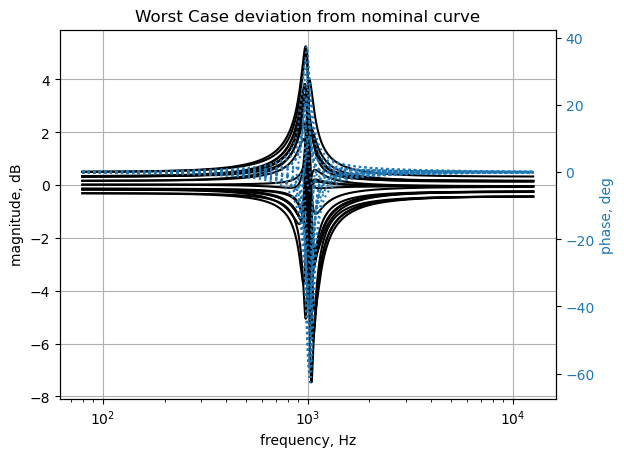

In [66]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

for i in range(0,num):
    plt.semilogx(w/(2*np.pi), mag - mag_ans[i],'-k')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-0.3,0.4))
plt.grid()
#plt.axvspan(20, 20e3, color='y', alpha=0.3)

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

for i in range(0,num):
    plt.semilogx(w/(2*np.pi), phase - phase_ans[i],':',color=color)  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Worst Case deviation from nominal curve')
plt.show()

The results above show that the worst case tolerance conditions yield deviations of -0.19 to 0.3 dB from the RIAA curve.  

## Summary
The circuit presented in this analysis is just one example of many circuits that can be found online. For each design to be evaluated, some type of side by side analysis should be used to down select. This notebook can be used as a template for any comparative analysis.

The circuit in the app note appears to have low frequency group delay that might be an issue. Also the deviation from the RIAA curve using normal component tolerances does not meet the 0.1 dB requirement. The worst case analysis also confirms this. The circuit employs an expensive 200$\mu$ Farad film capacitor. The circuit is missing a subsonic filter.